`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

### Import packages

In [1]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

### Functions

In [3]:
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

def calc_PpCO2(ds):
    p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)  # 0 is just a filler rn 
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = p, 
                        temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2_out'])

def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)
    
def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None):
    meridionalsection(ax,da,clims)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)

### Get some datasets!

In [4]:
z_kwargs = {'consolidated': True, 'use_cftime': True}
query_2 = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id='fgco2',
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'NorESM2-LM', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat_2 = col.search(**query_2)

# print(cat.df['source_id'].unique())
dd_fgco2_old = cat_2.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


### Combine

In [5]:
dd_fgco2 = combine_datasets(
    dd_fgco2_old,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_fgco2.keys())

['CESM2-WACCM-FV2.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon']

# Stereo Projs of `fgco2`

In [9]:
dd_fgco2['CESM2-FV2.gr.historical.Omon'].fgco2

<xarray.DataArray 'fgco2' (time: 1980, y: 180, x: 360)>
dask.array<xarray-fgco2, shape=(1980, 180, 360), dtype=float32, chunksize=(192, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes: (12/20)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Gas exchange flux of CO2 (positive into ocean)
    frequency:      mon
    id:             fgco2
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Downward Mass Flux of Carbon as CO2 [kgC m-2 s-1]
    type:           real
    units:          kg m-2 s-1
    variable_id:    fgco2

## 0m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

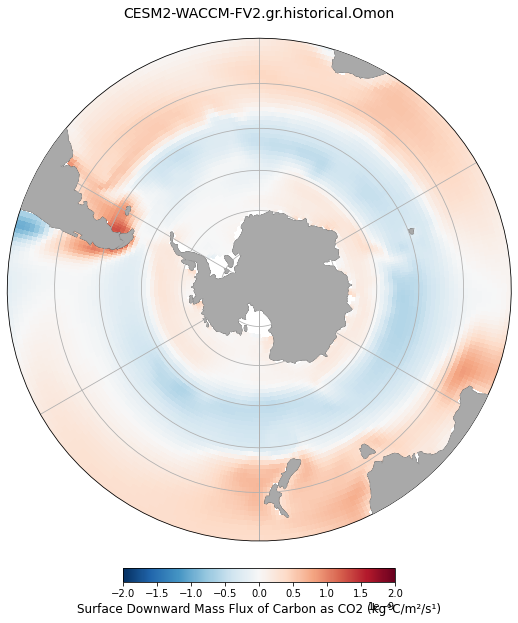

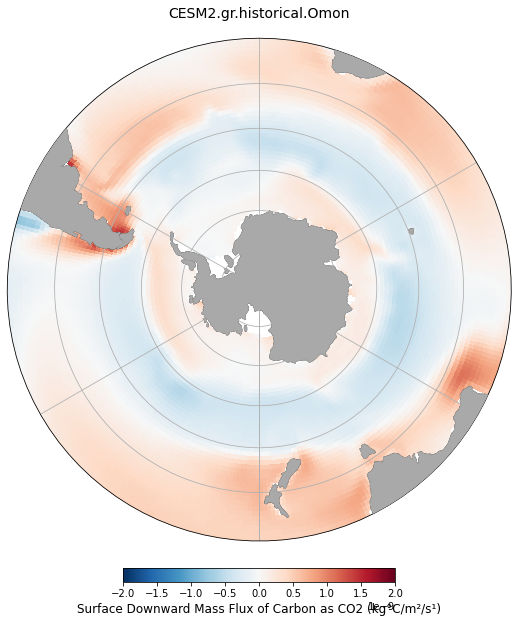

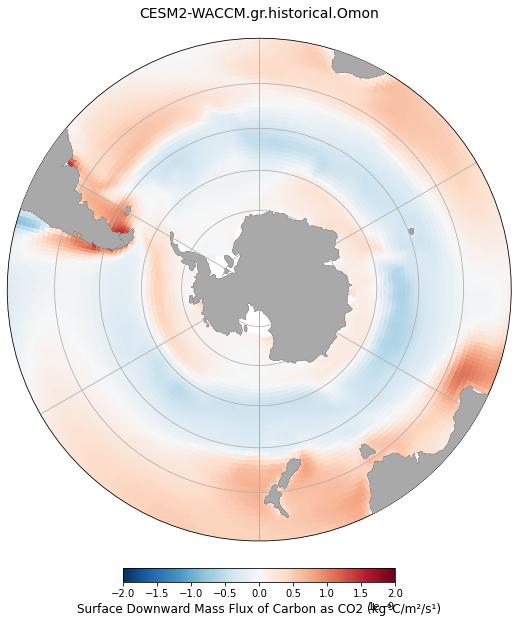

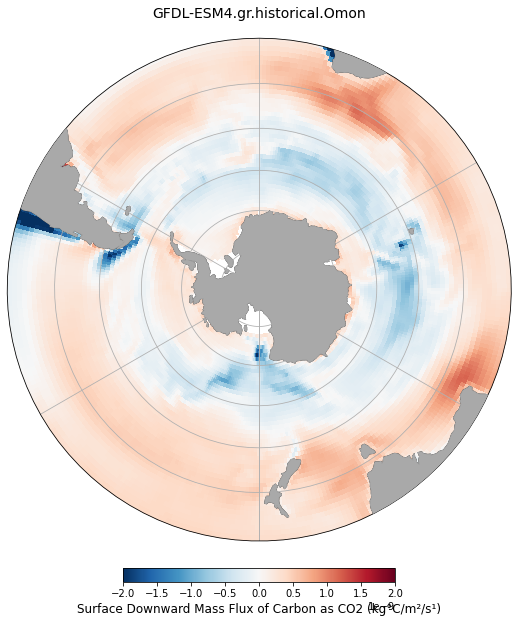

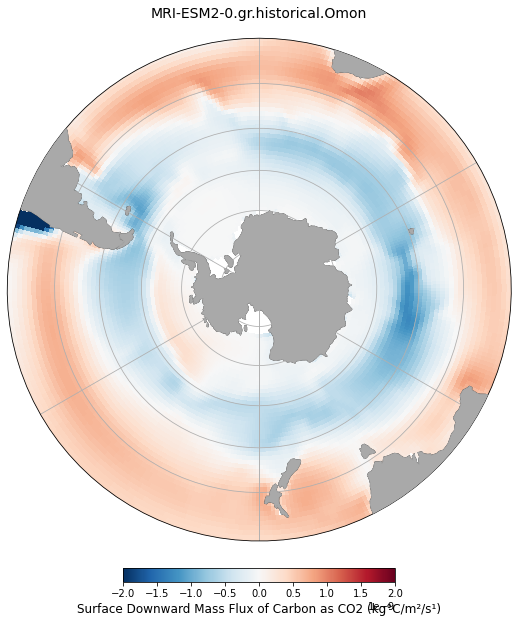

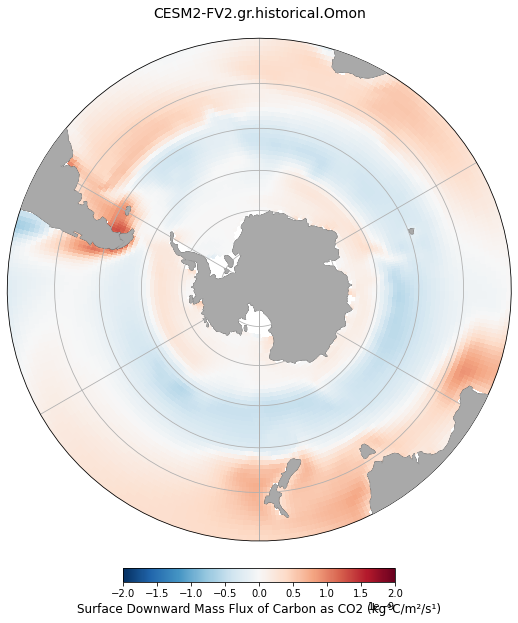

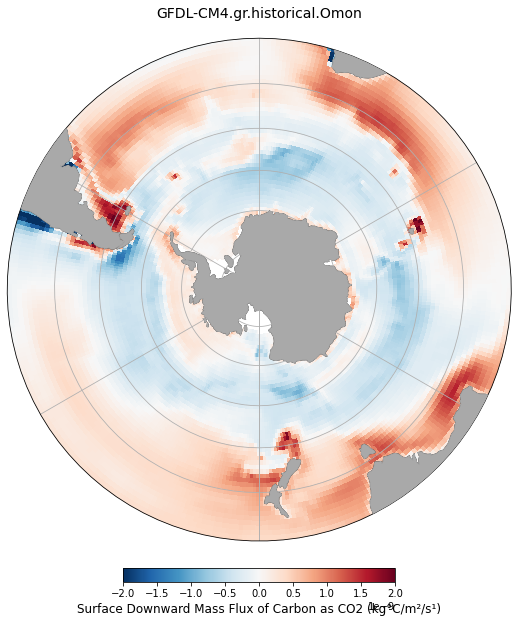

In [25]:
for name, ds_fgco2 in dd_fgco2.items():
    #ax = axarr_DIC.flat[ax_idx]
#     print('Surface Downward Mass Flux of Carbon as CO2 (kg\xb0C/m\u00b2/s\u00b9)')
    surf = ds_fgco2.fgco2.isel(time = slice(0, 239)).mean('time', keep_attrs=True)

    lat = surf.lat.transpose('y','x')
#     print(lat)
    lon = surf.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='RdBu_r',cbar_label= 'Surface Downward Mass Flux of Carbon as CO2 (kg\xb0C/m\u00b2/s\u00b9)',
                  title=name,plot_type='pcolormesh'
                  ,clims=[-2e-9,2e-9]
                 )
#     plt.savefig(name+'THETAO_0m_stereoproj_20yr.png')

## Super lame attempt to do all the stereographic projs at once
When I used `vmin` and `vmax` it fails/doesn't plot anything. But when I don't use `vmin` and `vmax` all the subfigs use very different cbar ranges. I'm not sure this will ever work, so doing individual stereo projs might be the move

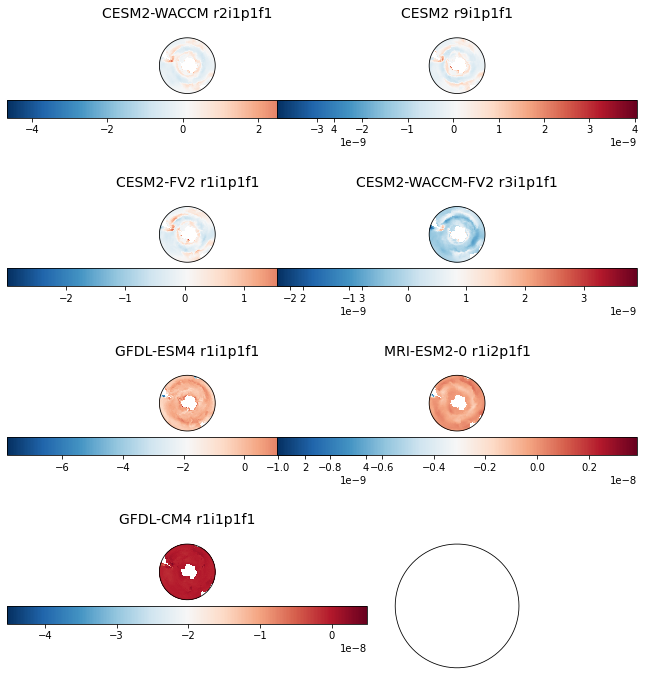

In [6]:
fig, axarr = plt.subplots(nrows = 4, ncols=2, figsize=[10,10], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 4.5)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds_fgco2 in dd_fgco2.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
#     ax.gridlines()
#     ax.coastlines()
    
    title=ds_fgco2.attrs['source_id']+ ' '+ds_fgco2.attrs['variant_label']
    ax.set_title(title,fontsize=14,pad = 20)
    
    
    Z = ds_fgco2.fgco2.isel(time = 0)
    lat = ds_fgco2.lat.transpose('y','x')
    lon = ds_fgco2.lon.transpose('y','x')
    X = lon
    Y = lat
    
    im = ax.pcolormesh(X,Y,Z,cmap='RdBu_r', transform = crs_source, shading = 'auto')
    
#     cbar_label = 'Surface Downward Flux of Total CO2 (kg m-2 s-1)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.5, pad=0.05)
#     cbar.set_label(cbar_label, fontsize = 8)
    
    ax_idx += 1

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

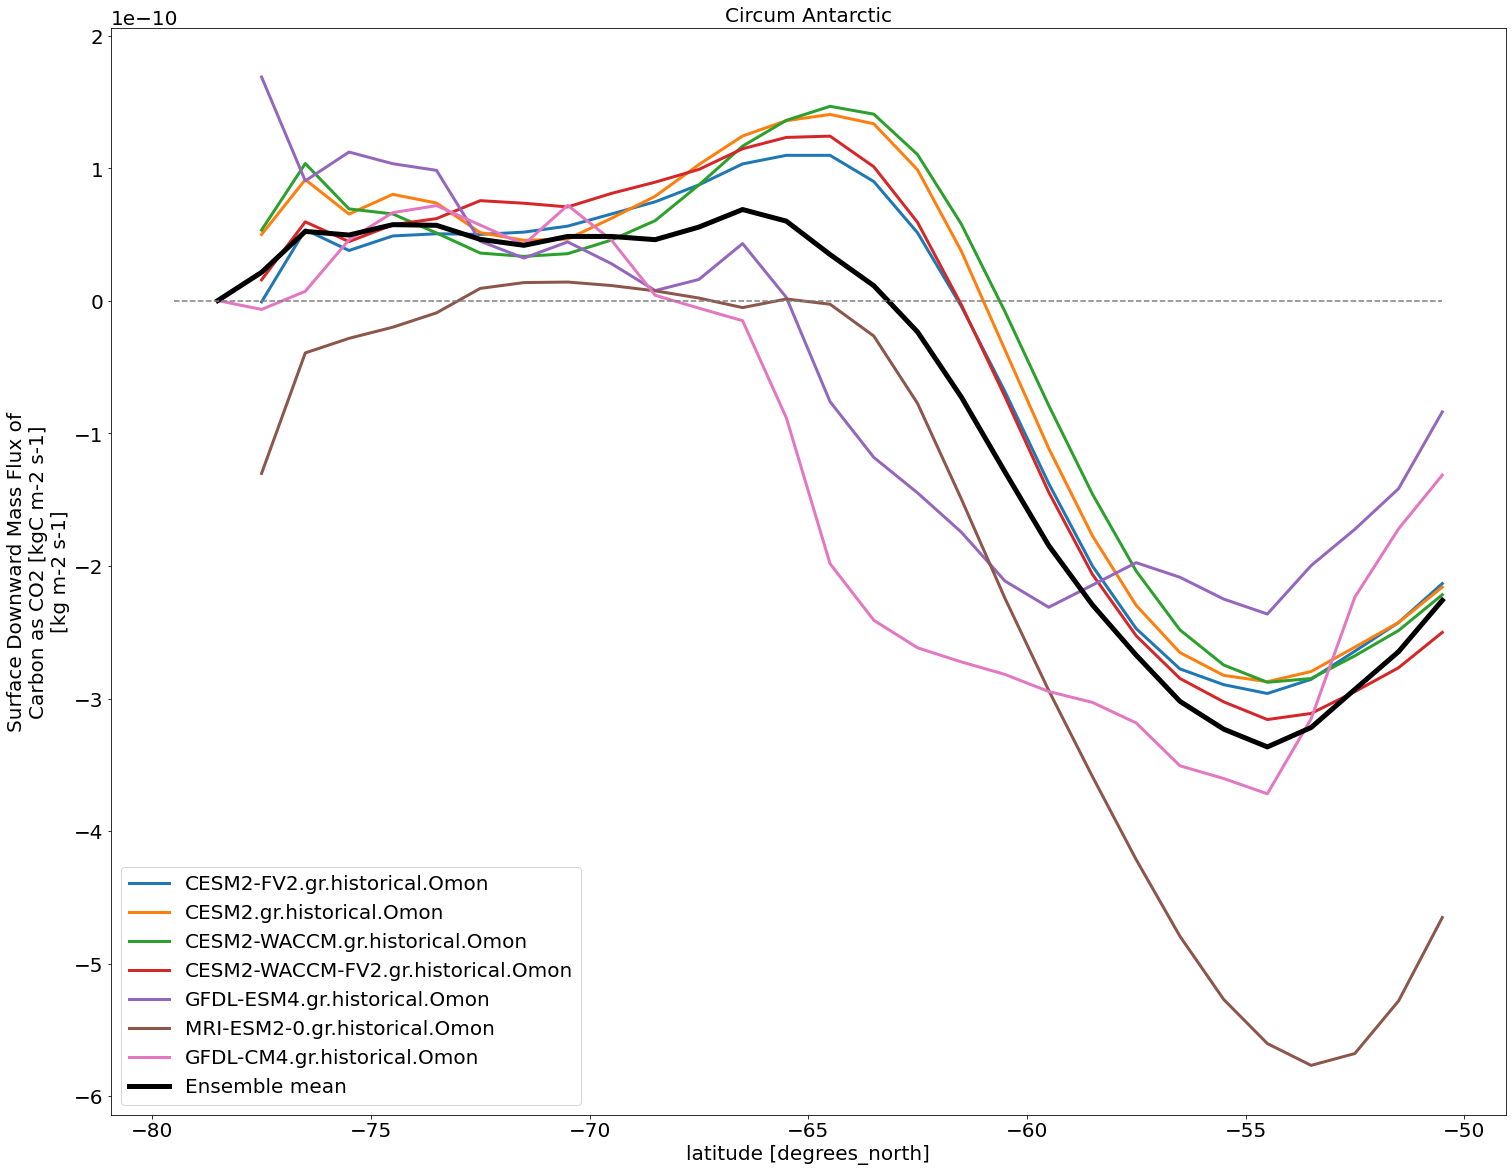

In [9]:
# fig_1, axarr_1 = plt.subplots(nrows = 7, figsize=[18,12])
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 20)    
plt.rc('axes', labelsize= 20)
plt.rc('figure', titlesize=20)
temp={}


ax_idx = 0
for name, ds in dd_fgco2.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = ds.fgco2.isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(ar.y[0:40], ar[0:40], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar

mn = np.nanmean(list(temp.values()), axis=0)
plt.plot(ar.y[0:40], mn[0:40], lw = 5, label = 'Ensemble mean', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel(dd_fgco2['CESM2-FV2.gr.historical.Omon'].fgco2.long_name)

zr = xr.zeros_like(dd_fgco2['CESM2-FV2.gr.historical.Omon'].fgco2)
zr.isel(x = 0, time = 0)[10:40].plot(linestyle = 'dashed')
# ax = plt.gca
# box = ax.get_position()
# ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower left'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic')
plt.rcParams["figure.figsize"] = (25,20)

plt.savefig('fgco2_line_circum.png')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

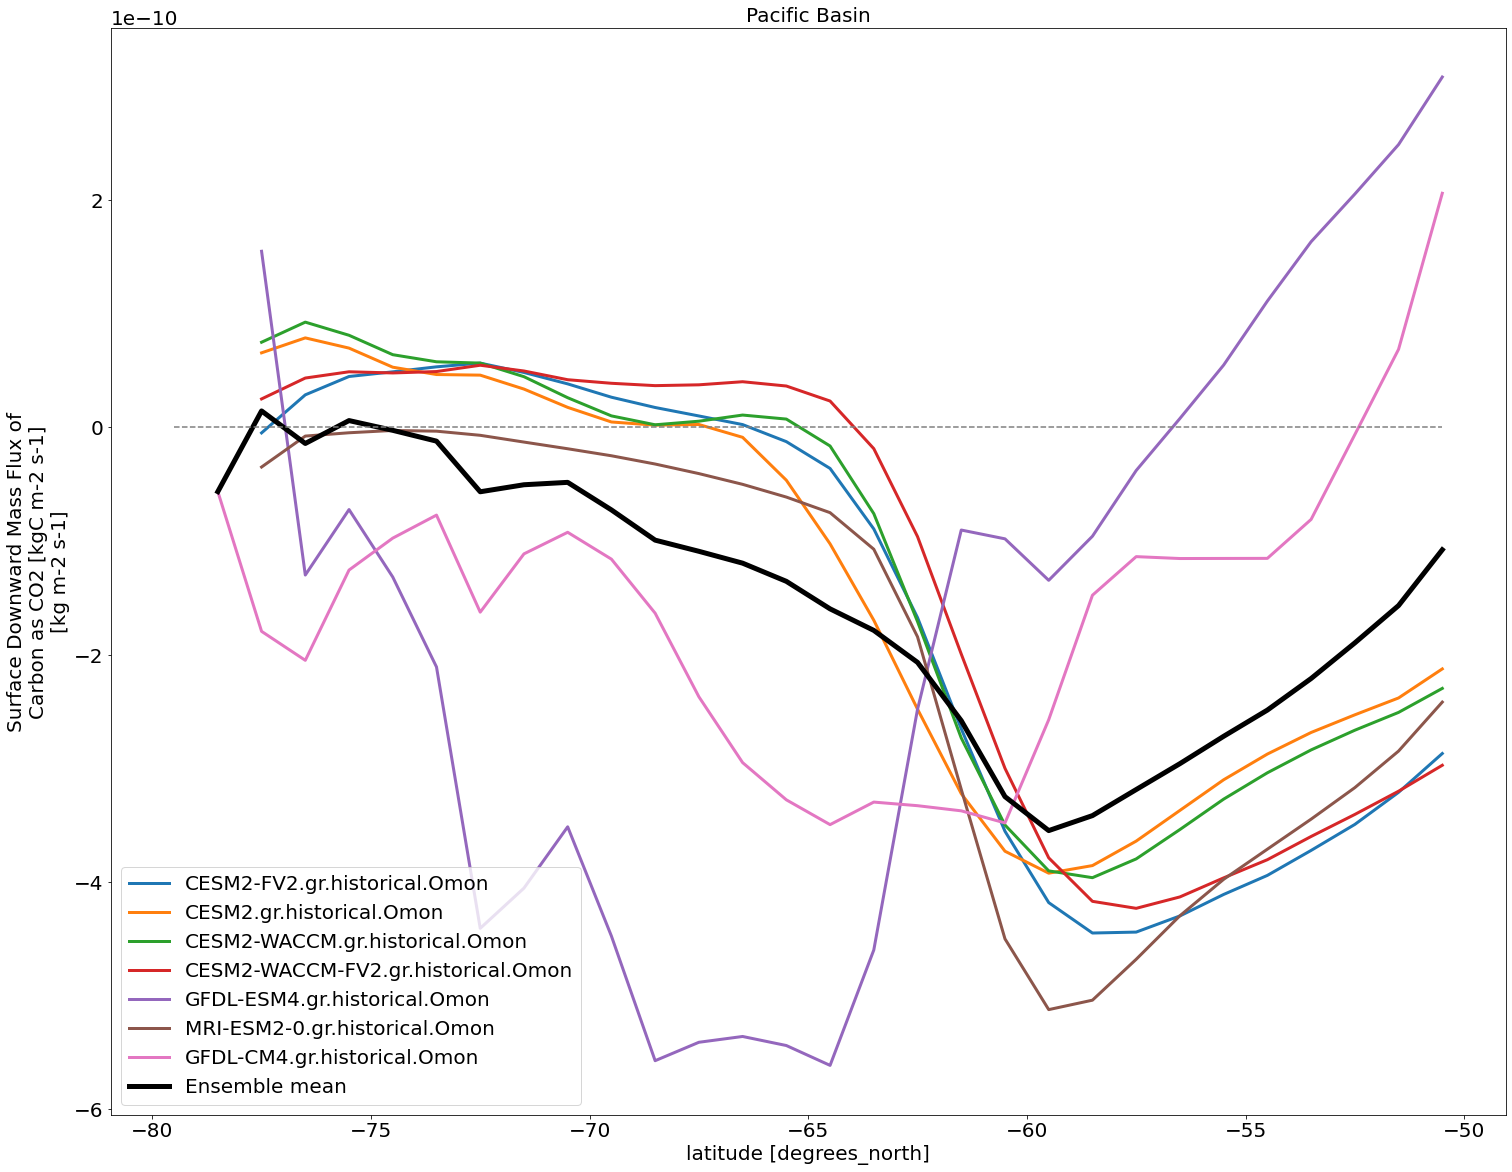

In [13]:
# fig_1, axarr_1 = plt.subplots(nrows = 7, figsize=[18,12])
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 20)    
plt.rc('axes', labelsize= 20)
plt.rc('figure', titlesize=20)
temp={}


ax_idx = 0
for name, ds in dd_fgco2.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(ar.y[0:40], ar[0:40], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar

mn = np.nanmean(list(temp.values()), axis=0)
plt.plot(ar.y[0:40], mn[0:40], lw = 5, label = 'Ensemble mean', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel(dd_fgco2['CESM2-FV2.gr.historical.Omon'].fgco2.long_name)

zr = xr.zeros_like(dd_fgco2['CESM2-FV2.gr.historical.Omon'].fgco2)
zr.isel(x = 0, time = 0)[10:40].plot(linestyle = 'dashed')
# ax = plt.gca
# box = ax.get_position()
# ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower left'
#     , borderaxespad=0.
)
plt.title('Pacific Basin')
plt.rcParams["figure.figsize"] = (25,20)
plt.savefig('fgco2_line_pacific.png')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

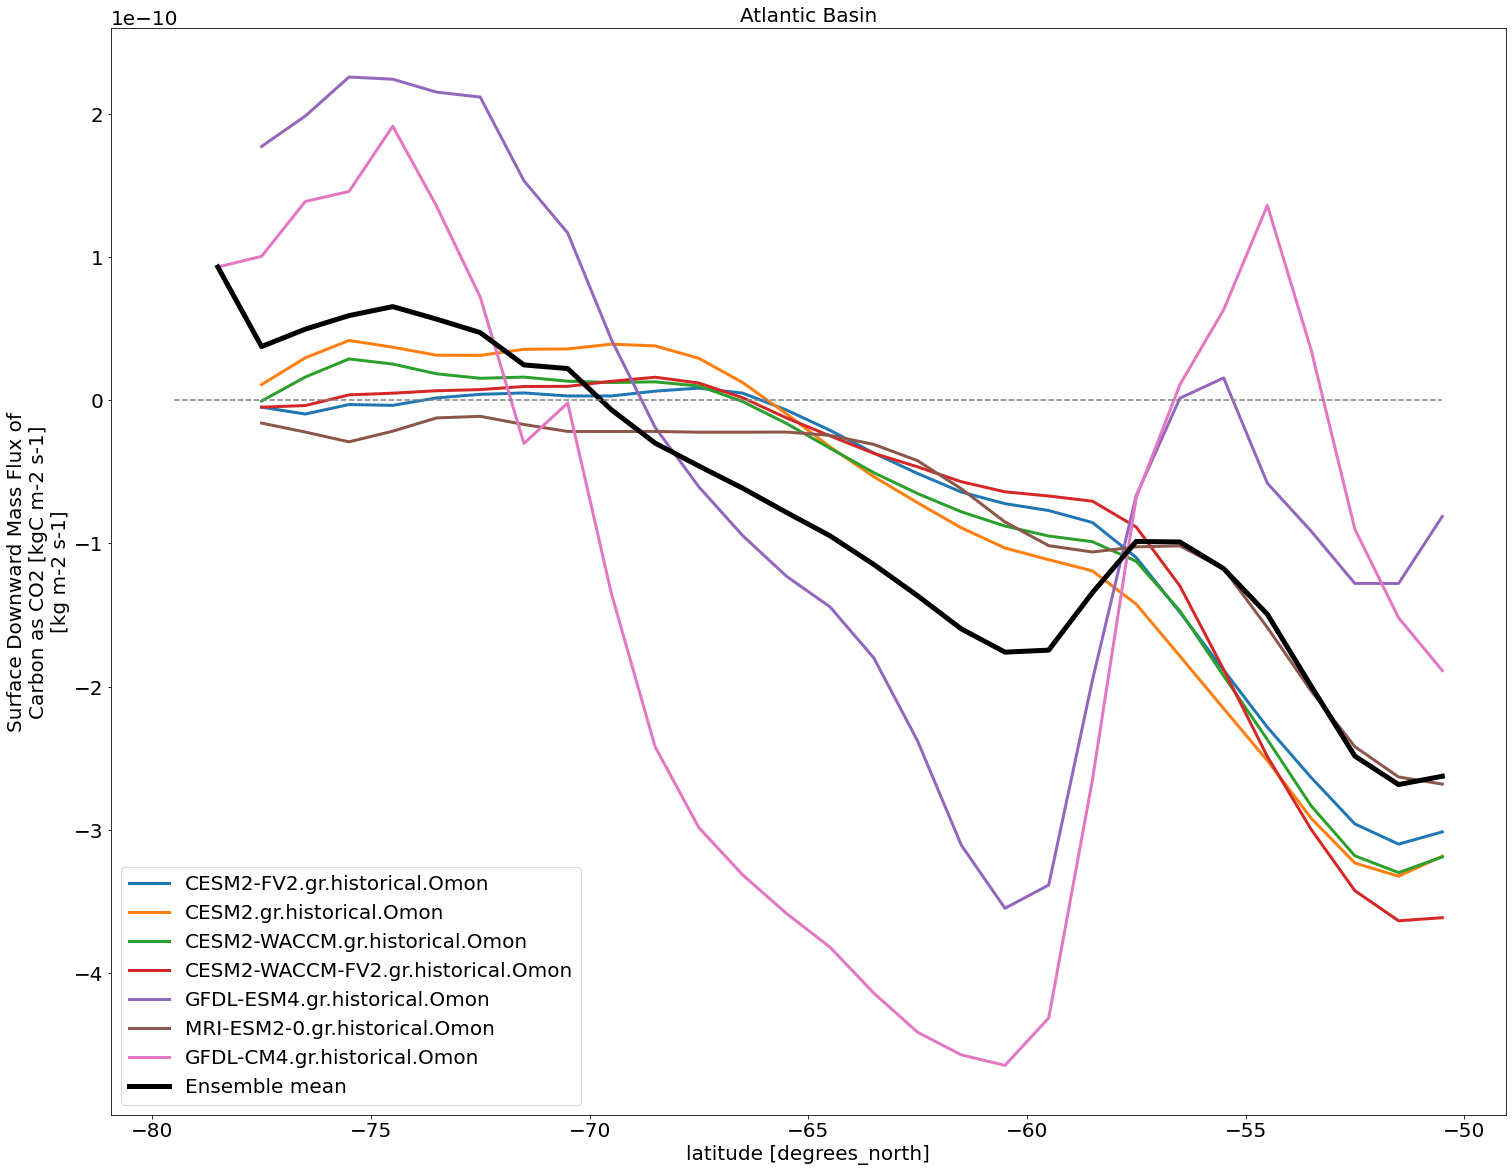

In [11]:
# fig_1, axarr_1 = plt.subplots(nrows = 7, figsize=[18,12])
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 20)    
plt.rc('axes', labelsize= 20)
plt.rc('figure', titlesize=20)
temp={}


ax_idx = 0
for name, ds in dd_fgco2.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = ds.fgco2.where(np.logical_and(ds.lon<=360, ds.lon>=320), drop=True).isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(ar.y[0:40], ar[0:40], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar

mn = np.nanmean(list(temp.values()), axis=0)
plt.plot(ar.y[0:40], mn[0:40], lw = 5, label = 'Ensemble mean', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel(dd_fgco2['CESM2-FV2.gr.historical.Omon'].fgco2.long_name)

zr = xr.zeros_like(dd_fgco2['CESM2-FV2.gr.historical.Omon'].fgco2)
zr.isel(x = 0, time = 0)[10:40].plot(linestyle = 'dashed')
# ax = plt.gca
# box = ax.get_position()
# ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower left'
#     , borderaxespad=0.
)
plt.title('Atlantic Basin')
plt.rcParams["figure.figsize"] = (25,20)
plt.savefig('fgco2_line_atlantic.png')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

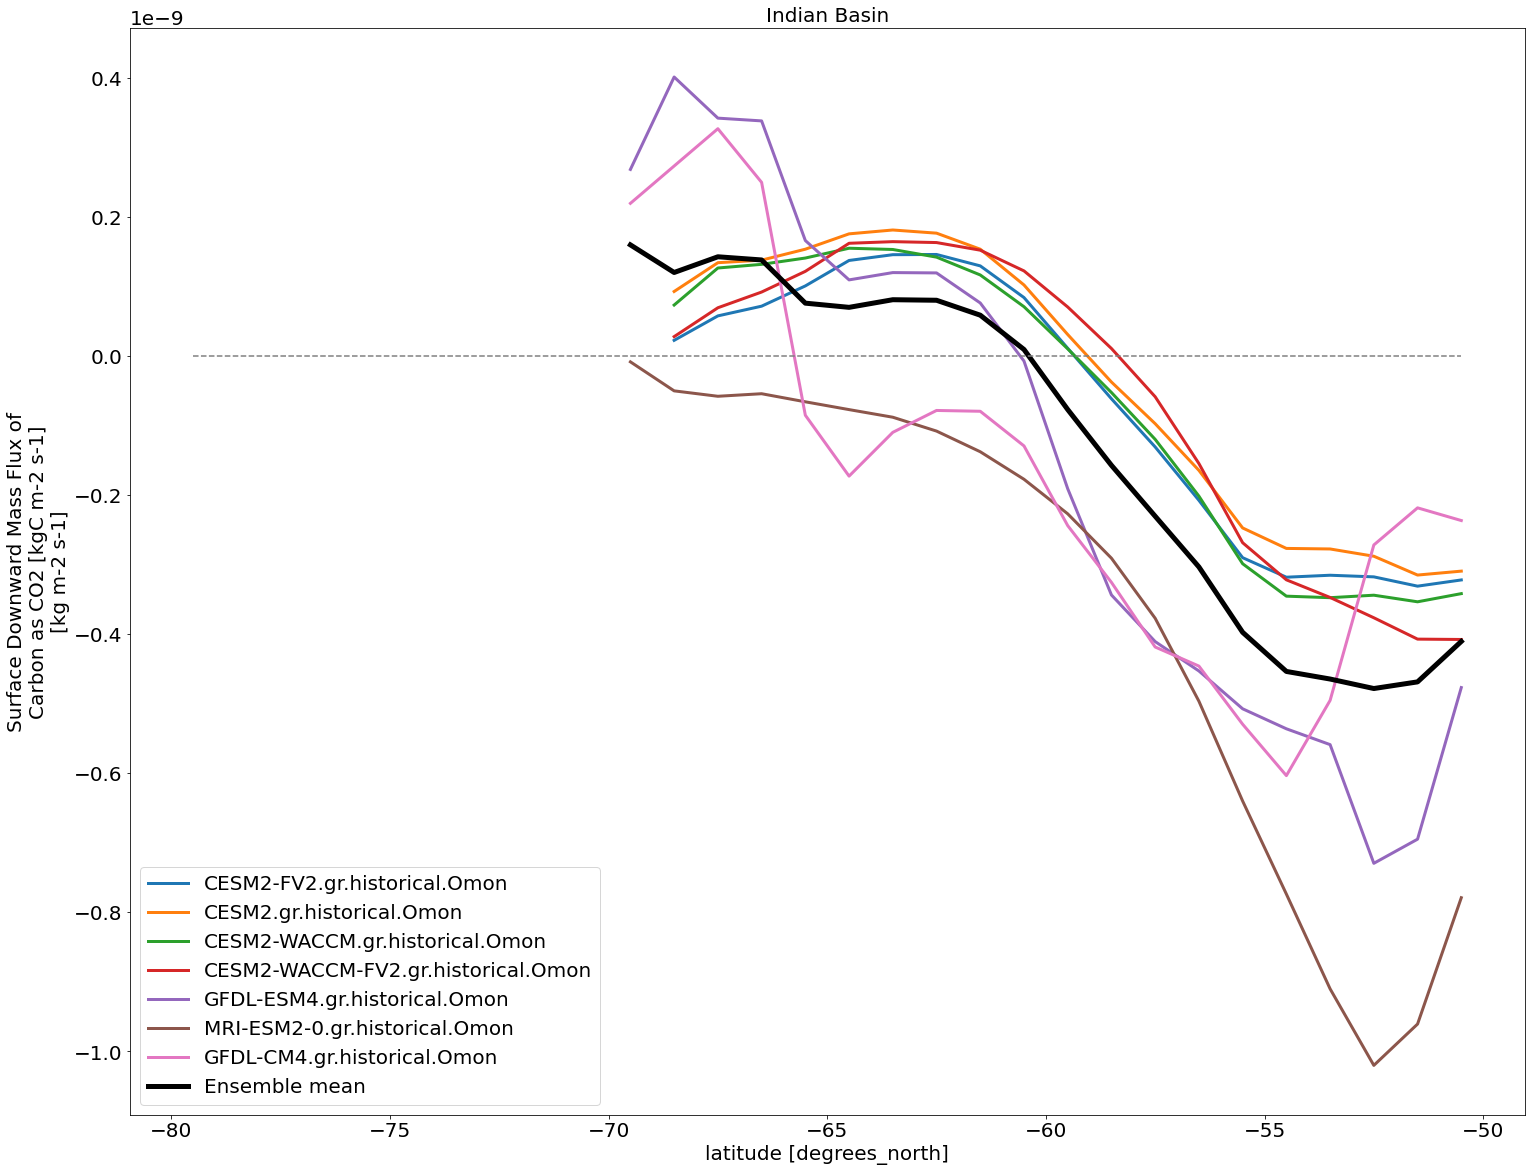

In [12]:
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 20)    
plt.rc('axes', labelsize= 20)
plt.rc('figure', titlesize=20)
temp={}


ax_idx = 0
for name, ds in dd_fgco2.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = ds.fgco2.where(np.logical_and(ds.lon<=90, ds.lon>=70), drop=True).isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(ar.y[0:40], ar[0:40], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar

mn = np.nanmean(list(temp.values()), axis=0)
plt.plot(ar.y[0:40], mn[0:40], lw = 5, label = 'Ensemble mean', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel(dd_fgco2['CESM2-FV2.gr.historical.Omon'].fgco2.long_name)

zr = xr.zeros_like(dd_fgco2['CESM2-FV2.gr.historical.Omon'].fgco2)
zr.isel(x = 0, time = 0)[10:40].plot(linestyle = 'dashed')
# ax = plt.gca
# box = ax.get_position()
# ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower left'
#     , borderaxespad=0.
)
plt.title('Indian Basin')
plt.rcParams["figure.figsize"] = (25,20)
plt.savefig('fgco2_line_indian.png')